<a href="https://colab.research.google.com/github/MishkaDewlok/PDAN8412_POE/blob/main/PDAN8412_POE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mishka Dewlok

ST10219921

PDAN8412 POE - Convolutional Neural Networks (CNN)

Dataset sourced from Kaggle at: https://www.kaggle.com/datasets/zalando-research/fashionmnist

**Setup:** This code block represents a simple set up which installs the required libraries and configures the environment.  It then downloads the Fashion-MNIST dataset from Kaggle, extracts it into a local folder, and displays the downloaded files. This prepares the dataset for later Spark-based preprocessing and CNN model training.

In [ ]:
#basic setup

# Install Kaggle and PySpark
!pip install -q kaggle pyspark

import os
import numpy as np
import pandas as pd

from google.colab import files

# Upload kaggle.json
print("Upload the kaggle.json file...")
uploaded = files.upload()

# Handle whatever name
if len(uploaded) == 0:
    raise ValueError("No file uploaded. Upload kaggle.json.")

kaggle_filename = list(uploaded.keys())[0]
print("Uploaded file detected as:", kaggle_filename)

# Save kaggle.json to the correct location
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_path = '/root/.kaggle/kaggle.json'

with open(kaggle_path, 'wb') as f:
    f.write(uploaded[kaggle_filename])


!chmod 600 /root/.kaggle/kaggle.json


os.makedirs('./kaggle_data', exist_ok=True)

#  Download the Fashion-MNIST dataset from Kaggle
zip_path = './kaggle_data/fashionmnist.zip'
if not os.path.exists(zip_path):
    print("Downloading Fashion-MNIST from Kaggle...")
    !kaggle datasets download -d zalando-research/fashionmnist -p ./kaggle_data
else:
    print("Fashion-MNIST zip already exists, skipping download.")

# Unzip
extract_dir = './kaggle_data/fashionmnist'
os.makedirs(extract_dir, exist_ok=True)

print("Unzipping dataset...")
!unzip -oq ./kaggle_data/fashionmnist.zip -d ./kaggle_data/fashionmnist

print("\nFiles in downloaded Fashion-MNIST folder:")
!ls -R ./kaggle_data/fashionmnist


Upload the kaggle.json file...


Saving kaggle.json to kaggle (3).json
Uploaded file detected as: kaggle (3).json
Fashion-MNIST zip already exists, skipping download.
Unzipping dataset...

Files in downloaded Fashion-MNIST folder:
./kaggle_data/fashionmnist:
fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


This loads the Fashion-MNIST dataset directly from TensorFlow’s built-in datasets. It imports TensorFlow, prints the TensorFlow version, and then downloads and splits the data into training and test sets. Finally, it prints the shapes of the image to confirm that 70 000 grayscale images have been loaded correctly.

In [ ]:
#LOAD FASHION-MNIST USING TENSORFLOW

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Load Fashion-MNIST
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Print shapes
print("Train shape:", fashion_x_train.shape, "Labels shape:", fashion_y_train.shape)
print("Test shape:", fashion_x_test.shape, "Labels shape:", fashion_y_test.shape)


TensorFlow version: 2.19.0
Train shape: (60000, 28, 28) Labels shape: (60000,)
Test shape: (10000, 28, 28) Labels shape: (10000,)


**Data Preprocessing:** This block performs the preprocessing required before training the CNN. The pixel values are normalised to a 0–1 range. The labels are kept as integers representing the 10 Fashion-MNIST classes of the dataset. A validation set is created from the training data using an 80/20 split.

In [ ]:
# PREPROCESSING

# Scale pixel values to [0, 1]
#GeeksforGeeks (2021).
#How to Normalize, Center, and Standardize Image Pixels in Keras? [online] GeeksforGeeks.
#Available at: https://www.geeksforgeeks.org/python/how-to-normalize-center-and-standardize-image-pixels-in-keras/.
#Date Accessed: 18 November 2025
x_train = fashion_x_train.astype("float32") / 255.0
x_test = fashion_x_test.astype("float32") / 255.0

# CNN receives images in shape
#Numpy.org. (2025).
#numpy.expand_dims — NumPy v2.3 Manual. [online]
#Available at: https://numpy.org/doc/2.3/reference/generated/numpy.expand_dims.html
#Date Accessed: 18 November 2025
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # (10000, 28, 28, 1)

y_train = fashion_y_train  # integers 0-9
y_test = fashion_y_test

# Create a validation split from the training set
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Print final dataset shapes
print("New train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)
print("Test shape:", x_test.shape, y_test.shape)


New train shape: (48000, 28, 28, 1) (48000,)
Validation shape: (12000, 28, 28, 1) (12000,)
Test shape: (10000, 28, 28, 1) (10000,)


**Exploratory Data Analysis (EDA):** It displays a grid of sample training images with their labels to provide a visual understanding of the data. It also plots a histogram of pixel intensities to inspect brightness distribution and confirm that the raw pixel values are well-spread and suitable for preprocessing. This step helps verify data quality before training the CNN.

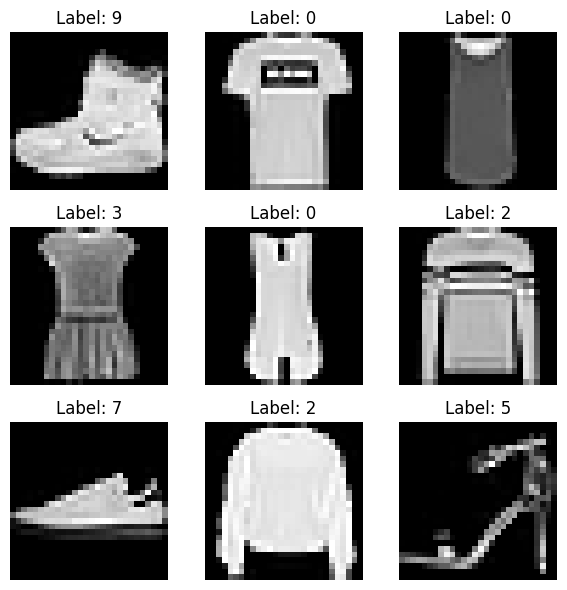

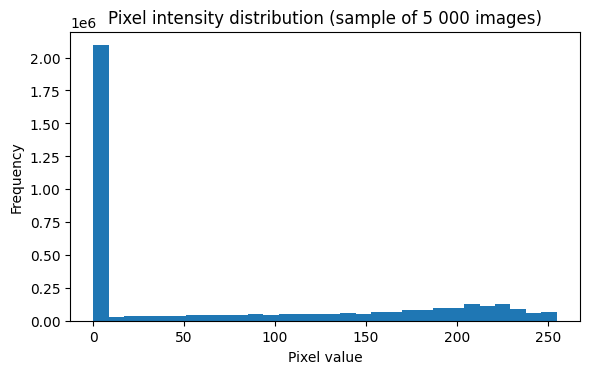

In [ ]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt

# Show 9 sample training images with labels
#matplotlib.org. (n.d.).
#matplotlib.pyplot — Matplotlib 3.5.2 documentation. [online]
#Available at: https://matplotlib.org/stable/api/pyplot_summary.html.
#Date Accessed: 18 November 2025
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fashion_x_train[i], cmap='gray')
    plt.title(f"Label: {fashion_y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Histogram of pixel values (using a subset for speed)
#numpy.org. (n.d.).
#numpy.reshape — NumPy v1.20 Manual. [online]
#Available at: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html.
#Date Accessed: 18 November 2025
flat_pixels = fashion_x_train[:5000].reshape(-1)
plt.figure(figsize=(6, 4))
plt.hist(flat_pixels, bins=30)
plt.title("Pixel intensity distribution (sample of 5 000 images)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Spark for the analysis:** This section initialises a Spark session using PySpark and performs Spark-based Exploratory Data Analysis (EDA) on a 10 000 sample subset of the training data. The images are converted into a Spark DataFrame with pixel values as features and the class label as the target. Using Spark, the code inspects the class distribution, draws simple pixel statistics per class (mean values for a few pixel columns), and checks for missing values.

In [ ]:
# START SPARK

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, size, mean as spark_mean

#spark.apache.org. (n.d.).
#Getting Started — PySpark 3.2.1 documentation. [online]
#Available at: https://spark.apache.org/docs/latest/api/python/getting_started/index.html.
#Date Accessed: 18 November 2025
spark = SparkSession.builder.appName("FashionMNIST_CNN_Analysis").getOrCreate()
spark

# use 10 000 sample for speed
sample_size = 10000
x_train_sample = x_train[:sample_size]
y_train_sample = y_train[:sample_size]

# Flatten images to 1D (28*28 = 784)
x_train_flat = x_train_sample.reshape(sample_size, -1)

# Create a pandas DataFrame for Spark
#Apache.org. (2025).
#pyspark.sql.SparkSession.createDataFrame — PySpark 4.0.1 documentation. [online]
#Available at: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.createDataFrame.html
#Date Accessed: 18 November 2025
df_pandas = pd.DataFrame(x_train_flat)
df_pandas['label'] = y_train_sample

df_pandas.head()

# CREATE SPARK DATAFRAME HERE
df_spark = spark.createDataFrame(df_pandas)
df_spark.printSchema()

# Count rows
print("Number of rows in Spark DataFrame:", df_spark.count())

# CLASS DISTRIBUTION USING SPARK

class_counts = df_spark.groupBy("label").count().orderBy("label")
class_counts.show()

# MEAN PIXEL VALUE BY CLASS

# Compute mean of a few pixel columns to keep it simple
pixel_cols = [str(i) for i in range(5)]

agg_exprs = [spark_mean(col(c)).alias(f"mean_pixel_{c}") for c in pixel_cols]

pixel_means = df_spark.groupBy("label").agg(*agg_exprs).orderBy("label")
pixel_means.show(truncate=False)

#CHECK FOR MISSING VALUESNOW

from pyspark.sql.functions import sum as spark_sum

null_counts = df_spark.select(
    *[spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]
)

print("Missing values per column in Spark sample:")
null_counts.show(truncate=False)


root
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- 25: double (nullable = true)
 |-- 26: double (nullable = true)
 |-- 27: double (nullable = true)
 |-- 28: double (nullable = true)
 |-- 29: double (nu

This block improves the Convolutional Neural Network (CNN). The model uses three convolution–max-pooling layers to extract features and L2 regularisation and a dropout layer are included to reduce overfitting. The final output layer uses softmax to classify images into the 10 Fashion-MNIST classes. Feature learning occurs implicitly within the convolutional layers, which automatically extract and select the most relevant spatial features from the image data.

In [ ]:
# CNN now adding dropout and regularisation

from tensorflow.keras import layers, models, regularizers

num_classes = 10 # dataset has 10 clothing categories

#TensorFlow. (n.d.).
#tf.keras.Sequential | TensorFlow Core v2.3.0. [online]
#Available at: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential.
#Date Accessed: 18 November 2025
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    #L2 regularisation to reduce overfitting
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    # Dropout layer to further prevent overfitting
    layers.Dropout(0.5),

    # softmax activation
    #TensorFlow. (n.d.).
    #tf.keras.layers.Dense | TensorFlow Core v2.3.0. [online]
    #Available at: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense.
    #Date Accessed: 18 November 2025
    layers.Dense(num_classes, activation='softmax')
])

#print summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training:** This block compiles and trains the CNN model. It sets the optimiser, loss function, and evaluation metrics used during training. It then trains the model on the preprocessed training data for 10 epochs while monitoring performance on the validation set.

In [ ]:
# Model Training
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',        # track validation loss
    patience=3,                # stop after 3 epochs with no improvement
    restore_best_weights=True # revert to the best model
)

#TensorFlow. (n.d.).
#Module: tf.keras | TensorFlow Core v2.4.1. [online]
#Available at: https://www.tensorflow.org/api_docs/python/tf/keras.
#Date Accessed: 18 November 2025
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6397 - loss: 1.0045 - val_accuracy: 0.8573 - val_loss: 0.4082
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8490 - loss: 0.4445 - val_accuracy: 0.8793 - val_loss: 0.3496
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8722 - loss: 0.3796 - val_accuracy: 0.8971 - val_loss: 0.3029
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8893 - loss: 0.3272 - val_accuracy: 0.9032 - val_loss: 0.2929
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8949 - loss: 0.3070 - val_accuracy: 0.9070 - val_loss: 0.2762
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9058 - loss: 0.2811 - val_accuracy: 0.9147 - val_loss: 0.2608
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9114 - loss: 0.2644 - val_accuracy: 0.9063 - val_loss: 0.2727
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9176 - loss: 0.2538 - val_accuracy: 0.

**Model Evaluation:** This block evaluates the trained CNN on the unseen test dataset. It computes the final test accuracy and test loss, which indicate how well the model generalises to new data.

In [ ]:
# EVALUATE ON TEST DATA

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9110
Test loss: 0.2734


**Model Evaluation & Metrics:** This section visualises the model’s training process and evaluates its performance on the test dataset. It plots the training and validation accuracy and loss curves to show how the model learned over each epoch, helping identify overfitting or underfitting. It then generates a classification report (precision, recall, F1-score) and a confusion matrix to provide detailed insights into how well the model performs on each of the 10 classes.

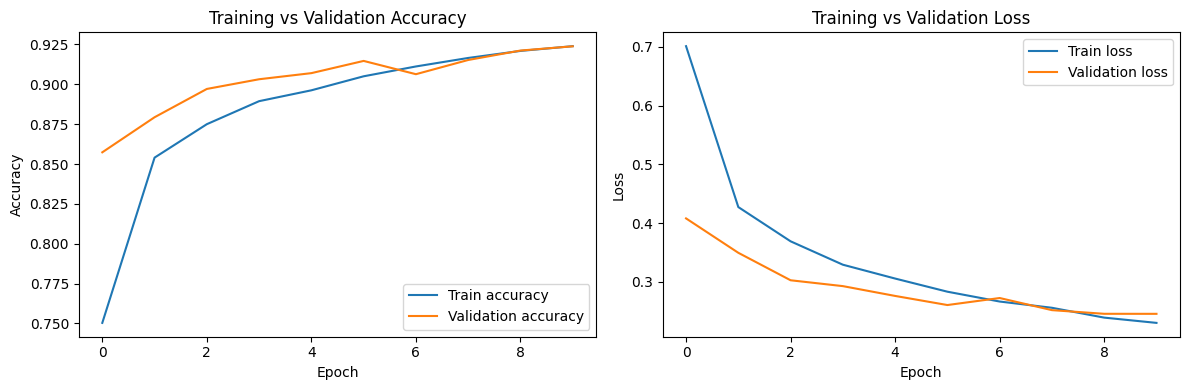

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.91      0.82      0.86      1000
           3       0.90      0.92      0.91      1000
           4       0.83      0.89      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.74      0.75      0.75      1000
           7       0.93      0.99      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



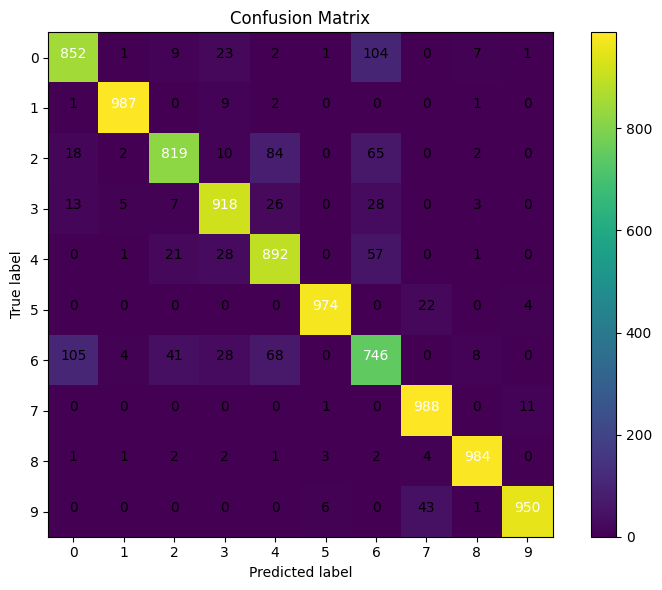

In [ ]:
# PLOT TRAINING AND VALIDATION ACCURACY / LOSS
#GeeksforGeeks (2021).
#Matplotlib Tutorial. [online] GeeksforGeeks.
#Available at: https://www.geeksforgeeks.org/python/matplotlib-tutorial/.
#Date Accessed: 18 November 2025
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# cONFUSION MATRIX AND CLASSIFICATION REPORT

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Predict on full test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report (precision, recall, F1)
print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
#scikit-learn (2019).
#sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation. [online] Scikit-learn.org.
#Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html.
#Date Accessed: 18 November 2025
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


This block computes advanced evaluation metrics for the CNN model using ROC-AUC, ROC curves, and probability distribution plots. It also visualises how well the model separates one specific class (“Dress”) from the others based on predicted probabilities.


Overall ROC-AUC (OvR, macro):   0.9946
Overall ROC-AUC (OvR, weighted): 0.9946


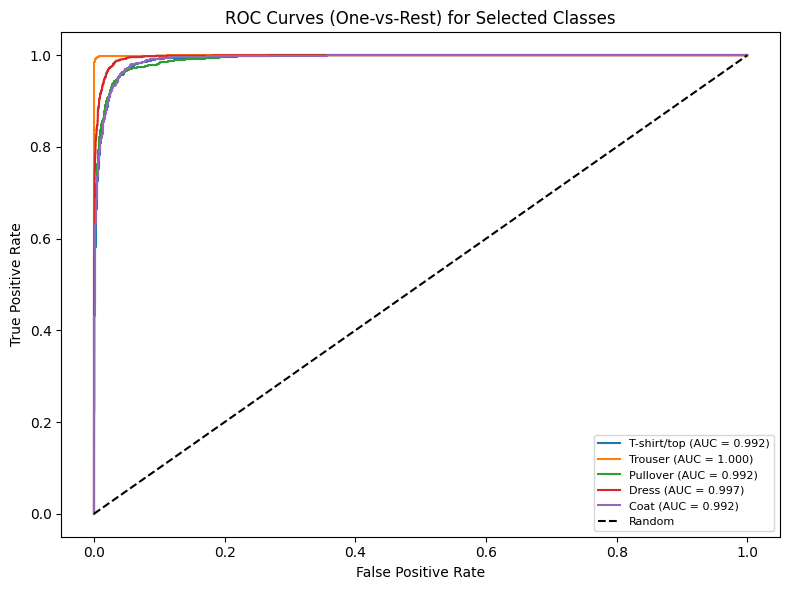

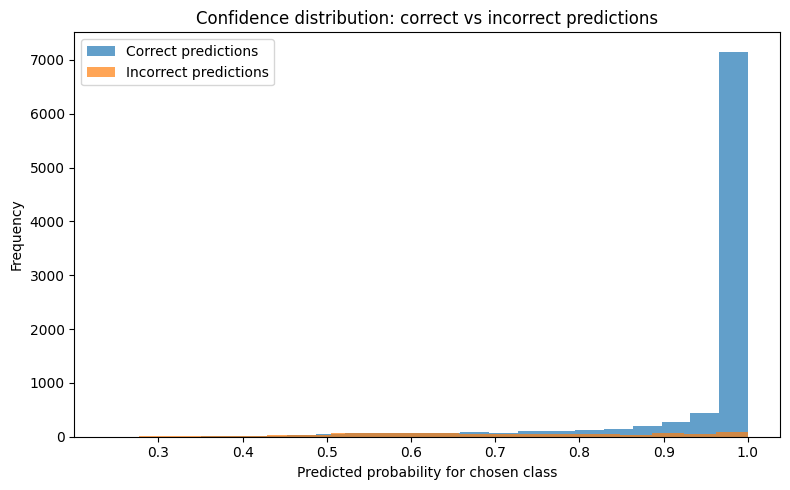

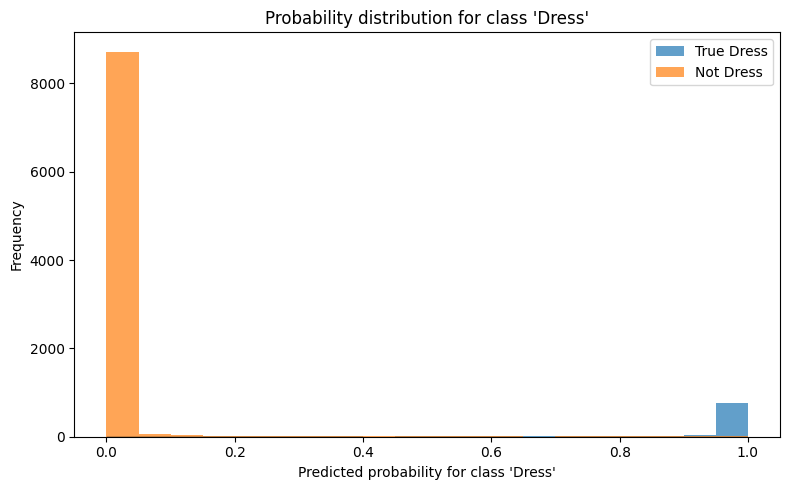

In [ ]:
# ROC-AUC, ROC CURVES AND PROBABILITY DISTRIBUTION PLOTS

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

n_classes = 10
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# OVERALL MULTI-CLASS ROC-AUC
#scikit-learn.org. (n.d.).
#sklearn.metrics.roc_auc_score — scikit-learn 0.23.2 documentation. [online]
#Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.
#Date Accessed: 18 November 2025
roc_auc_macro_ovr = roc_auc_score(
    y_test,
    y_pred_probs,
    multi_class="ovr",
    average="macro"
)
roc_auc_weighted_ovr = roc_auc_score(
    y_test,
    y_pred_probs,
    multi_class="ovr",
    average="weighted"
)

print(f"\nOverall ROC-AUC (OvR, macro):   {roc_auc_macro_ovr:.4f}")
print(f"Overall ROC-AUC (OvR, weighted): {roc_auc_weighted_ovr:.4f}")

# ROC CURVES PER CLASS
#scikit-learn. (n.d.).
#sklearn.preprocessing.label_binarize. [online]
#Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html.
#Date Accessed: 18 November 2025
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc_per_class = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot a few ROC curves
#Scikit-learn (n.d.).
#Receiver Operating Characteristic (ROC). [online] scikit-learn.
#Available at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html.
#Date Accessed: 18 November 2025
plt.figure(figsize=(8, 6))

selected_classes = [0, 1, 2, 3, 4]
for i in selected_classes:
    plt.plot(
        fpr[i], tpr[i],
        label=f"{class_names[i]} (AUC = {roc_auc_per_class[i]:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) for Selected Classes")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

# PROBABILITY DISTRIBUTION PLOTS (MODEL CONFIDENCE)

# Max predicted probability for each sample (model confidence)
max_probs = np.max(y_pred_probs, axis=1)

# Mask for correct vs incorrect predictions
#matplotlib.org. (n.d.).
#matplotlib.pyplot.hist — Matplotlib 3.5.1 documentation. [online]
#Available at: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html.
#Date Accessed: 18 November 2025
correct_mask = (y_pred == y_test)
correct_conf = max_probs[correct_mask]
incorrect_conf = max_probs[~correct_mask]

plt.figure(figsize=(8, 5))
plt.hist(correct_conf, bins=20, alpha=0.7, label="Correct predictions")
plt.hist(incorrect_conf, bins=20, alpha=0.7, label="Incorrect predictions")

plt.xlabel("Predicted probability for chosen class")
plt.ylabel("Frequency")
plt.title("Confidence distribution: correct vs incorrect predictions")
plt.legend()
plt.tight_layout()
plt.show()

#PROBABILITY DISTRIBUTION FOR A SINGLE CLASS

target_class = 3  # for example, "Dress"
class_mask = (y_test == target_class)

class_probs = y_pred_probs[class_mask, target_class]
nonclass_probs = y_pred_probs[~class_mask, target_class]

plt.figure(figsize=(8, 5))
plt.hist(class_probs, bins=20, alpha=0.7, label=f"True {class_names[target_class]}")
plt.hist(nonclass_probs, bins=20, alpha=0.7, label=f"Not {class_names[target_class]}")

plt.xlabel(f"Predicted probability for class '{class_names[target_class]}'")
plt.ylabel("Frequency")
plt.title(f"Probability distribution for class '{class_names[target_class]}'")
plt.legend()
plt.tight_layout()
plt.show()

This block displays predictions for the first 10 test images. It shows both the true labels and the model’s predicted labels and visualises the images alongside the predictions. This helps assess how well the model performs on individual samples and provides an understanding of correct and incorrect predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Image 0: True = Ankle boot, Predicted = Ankle boot
Image 1: True = Pullover, Predicted = Pullover
Image 2: True = Trouser, Predicted = Trouser
Image 3: True = Trouser, Predicted = Trouser
Image 4: True = Shirt, Predicted = Shirt
Image 5: True = Trouser, Predicted = Trouser
Image 6: True = Coat, Predicted = Coat
Image 7: True = Shirt, Predicted = Shirt
Image 8: True = Sandal, Predicted = Sandal
Image 9: True = Sneaker, Predicted = Sneaker


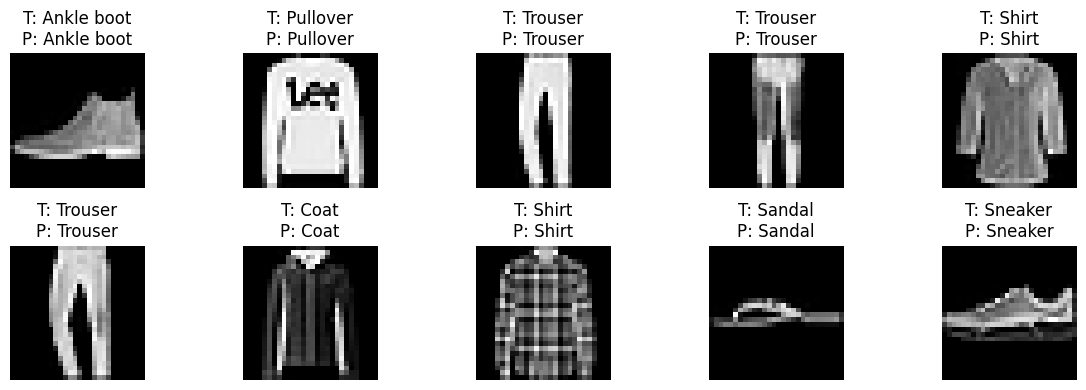

In [ ]:
# PREDICT ON A FEW TEST IMAGES

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Predict class probabilities for the first 10 test images
#numpy (n.d.).
#numpy.argmax — NumPy v1.23 Manual. [online] numpy.org.
#Available at: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html.
#Date Accessed: 18 November 2025
pred_probs = model.predict(x_test[:10])
pred_labels = np.argmax(pred_probs, axis=1)

for i in range(10):
    true_label = class_names[y_test[i]]
    pred_label = class_names[pred_labels[i]]
    print(f"Image {i}: True = {true_label}, Predicted = {pred_label}")

import matplotlib.pyplot as plt

# Display the first 10 test images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"T: {class_names[y_test[i]]}\nP: {class_names[pred_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
